In [24]:
example_file_maxquant = "../../test_data/system_tests/organellar_maps/evidence.txt.maxquant_evidence_benchmark.aq_reformat.tsv"
protein_groups_file = "../../test_data/system_tests/organellar_maps/proteinGroups.txt"

In [25]:
import pandas as pd
def find_protid_by_genename(protein_groups_file, gene_name):
    protein_groups_df = pd.read_csv(protein_groups_file, sep = "\t", usecols = ["id", "Gene names"])
    gene2id_dict = dict(zip( protein_groups_df["Gene names"],protein_groups_df["id"]))
    return gene2id_dict.get(gene_name)


protid = find_protid_by_genename(protein_groups_file, "AVEN")
print(protid)

6270


In [26]:
import pandas as pd
mq_df = pd.read_csv(example_file_maxquant, sep = "\t")
display(max(mq_df["protein"]))

'999'

Map1_12K    Map1_1K  Map1_24K    Map1_3K  \
protein ion                                                                   
0       _DGSASEVPSELSERPK_3             NaN  24.657419       NaN  26.759007   
        _EDFVPNTEK_2                    NaN        NaN       NaN  25.814847   
1       _EFHQAGKPIGLCCIAPVLAAK_3        NaN        NaN       NaN  27.860827   
        _EFHQAGKPIGLCCIAPVLAAK_4        NaN  26.961574       NaN  29.502411   
        _EFHQAGK_2                      NaN        NaN       NaN        NaN   
...                                     ...        ...       ...        ...   
998     _VSHSEDDCLAFK_3                 NaN        NaN       NaN        NaN   
999     _FVYTPAMESVCGYFHR_3       25.814236        NaN       NaN  26.544393   
        _GFQALGDAADIR_2                 NaN        NaN       NaN        NaN   
        _HLACLPR_2                      NaN        NaN       NaN        NaN   
        _TYTVGCEECTVFPCLSIPCK_3   25.271312        NaN       NaN        NaN   

                                    Map1_6K  Map1_80K   Map1_Cyt   Map2_12K  \
protein ion                                                                   
0       _DGSASEVPSELSERPK_3       26.579027       NaN        NaN        NaN   
        _EDFVPNTEK_2              25.075778       NaN        NaN        NaN   
1       _EFHQAGKPIGLCCIAPVLAAK_3  27.876837       NaN        NaN        NaN   
        _EFHQAGKPIGLCCIAPVLAAK_4  29.191288       NaN        NaN        NaN   
        _EFHQAGK_2                26.103336       NaN  27.900638        NaN   
...                                     ...       ...        ...        ...   
998     _VSHSEDDCLAFK_3                 NaN       NaN        NaN        NaN   
999     _FVYTPAMESVCGYFHR_3       26.064639       NaN        NaN  26.291950   
        _GFQALGDAADIR_2                 NaN       NaN        NaN        NaN   
        _HLACLPR_2                      NaN       NaN        NaN        NaN   
        _TYTVGCEECTVFPCLSIPCK_3   25.044936       NaN        NaN  25.165188   

                                    Map2_1K  Map2_24K  ...    Map2_6K  \
protein ion                                            ...              
0       _DGSASEVPSELSERPK_3       24.787807       NaN  ...  26.228154   
        _EDFVPNTEK_2                    NaN       NaN  ...        NaN   
1       _EFHQAGKPIGLCCIAPVLAAK_3        NaN       NaN  ...  27.583194   
        _EFHQAGKPIGLCCIAPVLAAK_4  26.435140       NaN  ...  29.159906   
        _EFHQAGK_2                      NaN       NaN  ...        NaN   
...                                     ...       ...  ...        ...   
998     _VSHSEDDCLAFK_3                 NaN       NaN  ...        NaN   
999     _FVYTPAMESVCGYFHR_3             NaN       NaN  ...  26.367330   
        _GFQALGDAADIR_2                 NaN       NaN  ...  26.375888   
        _HLACLPR_2                      NaN       NaN  ...  24.979500   
        _TYTVGCEECTVFPCLSIPCK_3         NaN       NaN  ...  25.269850   

                                  Map2_80K   Map2_Cyt   Map3_12K    Map3_1K  \
protein ion                                                                   
0       _DGSASEVPSELSERPK_3            NaN        NaN        NaN  24.891524   
        _EDFVPNTEK_2                   NaN        NaN        NaN        NaN   
1       _EFHQAGKPIGLCCIAPVLAAK_3       NaN        NaN        NaN        NaN   
        _EFHQAGKPIGLCCIAPVLAAK_4       NaN        NaN        NaN  26.656219   
        _EFHQAGK_2                     NaN  27.977983        NaN        NaN   
...                                    ...        ...        ...        ...   
998     _VSHSEDDCLAFK_3                NaN        NaN        NaN        NaN   
999     _FVYTPAMESVCGYFHR_3            NaN        NaN  27.253767  24.933281   
        _GFQALGDAADIR_2                NaN        NaN  26.253298        NaN   
        _HLACLPR_2                     NaN        NaN        NaN        NaN   
        _TYTVGCEECTVFPCLSIPCK_3        NaN        NaN        NaN        NaN   

 

/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear_cut' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear_cut' which already exists.
  matplotlib.cm.register_cmap(name, linmap)


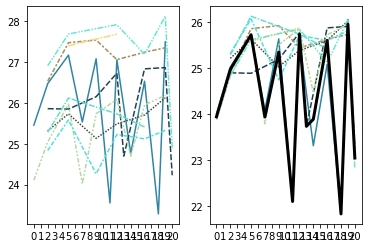

In [33]:
import pandas as pd
import directlfq.utils as lfq_utils
import directlfq.visualizations as lfq_viz

def load_mq_dataframe(example_mq_file):
    mq_df = pd.read_csv(example_mq_file, sep = "\t")
    mq_df = lfq_utils.index_and_log_transform_input_df(mq_df)
    return mq_df

mq_df = load_mq_dataframe(example_file_maxquant)
display(mq_df)

selected_prot = find_protid_by_genename(protein_groups_file, "AVEN")
comp_plotter = lfq_viz.IonTraceCompararisonPlotter(mq_df, str(selected_prot))

/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/Users/constantin/workspace/directlfq/directlfq/visualizations.py:47: UserWarning: Trying to register the cmap 'alphapept_linear_cut' which already exists.
  matplotlib.cm.register_cmap(name, linmap)


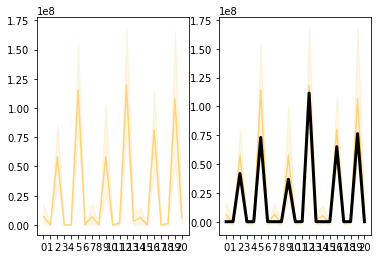

In [31]:

selected_prot = find_protid_by_genename(protein_groups_file, "AVEN")
comp_plotter = lfq_viz.IonTraceCompararisonPlotter(mq_df, str(selected_prot))